In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random
from matplotlib import pyplot as plt
from sgd_sim import train

In [2]:
# Set input dimension
v = 1000

# Set data and target complexity
alpha = 0.75
beta = 0.25

b = jnp.power(jnp.arange(v)+1,-beta)

key = random.key(0)

flops = jnp.logspace(4,7,10)
n_sims = 5
B = 1
gamma = 0.1
dims = [100,200]
tau = 0
n_flops = jnp.shape(flops)[0]
n_dims = len(dims)
risks = np.zeros((n_flops,n_dims))


for j, d in enumerate(dims):
    key, subkey_Z = random.split(key)
    one = jnp.ones(shape=(d,))
    Z = random.normal(subkey_Z, shape=(v,d)) / jnp.sqrt(d)
    W = tau / jnp.sqrt(d) * jnp.outer(b,one) + Z    
    for i, C in enumerate(flops):
        print(C)
        err = 0
        r = int(C // (B*d))
        for _ in range(n_sims):
            key, subkey_sgd = random.split(key)
            err_k = train(alpha,beta,gamma,B,v,d,r,W,subkey_sgd)
            err += err_k
        risks[i,j] = err / n_sims

2024-10-12 10:57:18.440811: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


10000.0
21544.355
46415.92
100000.0
215443.55
464158.72
1000000.0
2154435.5
4641592.0
10000000.0
10000.0
21544.355
46415.92
100000.0
215443.55
464158.72
1000000.0
2154435.5
4641592.0
10000000.0


Text(0, 0.5, 'Risk')

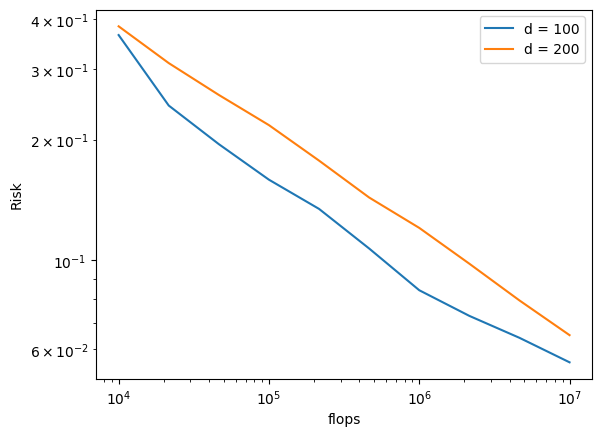

In [3]:
for j,d in enumerate(dims):
    plt.plot(flops,risks[:,j],label="d = {}".format(d))
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("flops")
plt.ylabel("Risk")